# How does theta modulated cells behave during sleep deprivation
- do they decrease their firing rate during SD more than non-theta modulated cells

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy.utils import neurons_util
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sd_sessions = subjects.sd.ratNday1+subjects.sd.ratSday3 + subjects.sd.ratUday4
nsd_sessions = subjects.nsd.ratNday2+subjects.nsd.ratSday2 + subjects.nsd.ratUday2


In [45]:
bin_size = 15*60
nQuantiles = 5

theta_mod_frate = pd.DataFrame()
for grp, sessions in zip(['sd','nsd'],[sd_sessions,nsd_sessions]):
    post_frate=[]
    quantiles=[]
    for sub, sess in enumerate(sessions):
        maze = sess.paradigm["maze"]
        post = sess.paradigm['post']
        maze_neurons = (
            sess.neurons.get_neuron_type("pyr")
            .time_slice(maze[0], maze[1])
            .get_above_firing_rate(0.1)
        )
        acg = neurons_util.calculate_neurons_acg(maze_neurons, bin_size=0.001, window_size=0.5)
        acg_right = acg[:, acg.shape[1] // 2 :]
        trough, peak = (acg_right[:, 50:70]).sum(axis=1), (acg_right[:, 100:140]).sum(
            axis=1
        )
        tmi = (peak - trough) / (peak + trough)

        quantiles.append(pd.qcut(tmi, q=nQuantiles, labels=False))

        neuron_ids_bool = np.isin(sess.neurons.neuron_ids,maze_neurons.neuron_ids)
        binspk = sess.neurons[neuron_ids_bool].time_slice(
                    post[0], post[0] + 5 * 3600
                ).get_binned_spiketrains(bin_size=bin_size)
        post_frate.append(binspk.spike_counts/bin_size)

    quantiles = np.concatenate(quantiles)
    post_frate = np.vstack(post_frate)
    assert len(quantiles) == post_frate.shape[0],'First dimension should match'

    quant_mean_frate = [
            np.nanmean(post_frate[quantiles == q, :], axis=0) for q in range(nQuantiles)
        ]
    quant_mean_frate = np.asarray(quant_mean_frate)
    first_bin = quant_mean_frate[:, 0]
    quant_mean_frate = quant_mean_frate / first_bin[:, np.newaxis]

    df = pd.DataFrame(
        quant_mean_frate, columns=np.arange(quant_mean_frate.shape[1])
    )
    df["grp"] = grp
    df["quantiles"] = np.arange(nQuantiles)
    theta_mod_frate = theta_mod_frate.append(df)

theta_mod_frate= pd.melt(
    theta_mod_frate,
    id_vars=["grp", "quantiles"],
    value_vars=np.arange(20),
    var_name=["bins"],
    value_name="frate",
    ignore_index=True,
)



(0.0, 1.0, 0.0, 1.0)

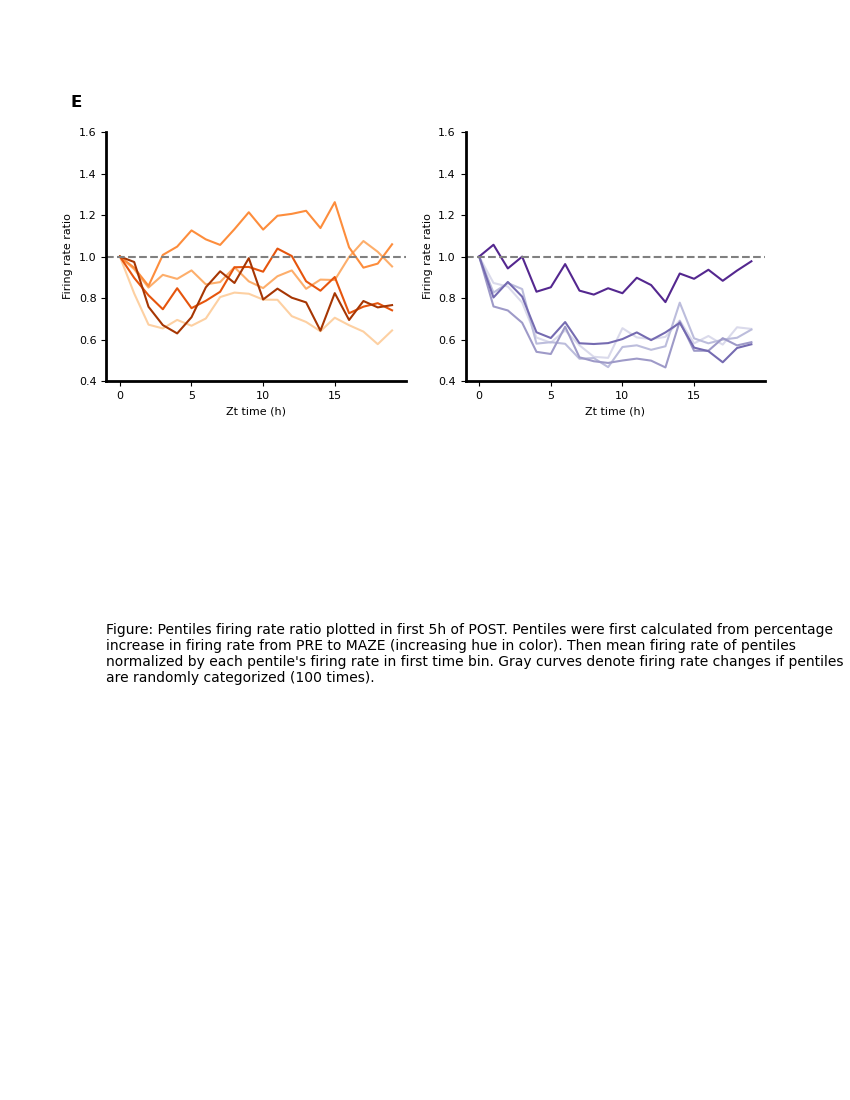

In [46]:
%matplotlib widget
import seaborn as sns
from palettable.colorbrewer.sequential import Oranges_6, Purples_6
from neuropy.plotting import Fig
figure = Fig()
fig,gs = figure.draw(grid=(3,2))

colors = list(subjects.sd_colors.values())
palette = [Oranges_6, Purples_6]
for i, grp in enumerate(["sd", "nsd"]):
    ax_1v5 = plt.subplot(gs[i])
    df = theta_mod_frate[(theta_mod_frate["grp"] == grp)]
    
    sns.lineplot(
        data=df,
        x="bins",
        y="frate",
        hue="quantiles",
        palette=palette[i].hex_colors[1:],
        legend=None,
        ax=ax_1v5
    )   
    # ax_1v5.set_yscale('log')
    ax_1v5.axhline(1,ls='--',color='gray')
    ax_1v5.set_ylim(bottom=0.4,top=1.6)
    ax_1v5.set_ylabel('Firing rate ratio')
    ax_1v5.set_xlabel('Zt time (h)')
    if i==0:
        figure.panel_label(ax_1v5,'E')

ax_caption = plt.subplot(gs[1, :])
ax_caption.text(
    0,
    0,
    "Figure: Pentiles firing rate ratio plotted in first 5h of POST. Pentiles were first calculated from percentage increase in firing rate from PRE to MAZE (increasing hue in color). Then mean firing rate of pentiles normalized by each pentile's firing rate in first time bin. Gray curves denote firing rate changes if pentiles are randomly categorized (100 times).",
    wrap=True,
)
ax_caption.axis("off")